In [1]:
# Titanic kaggle competition
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
# EXPLORING THE DATA
# Load the wholesale customers dataset
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
full_set = data.append(test_data)
full_set.set_index('PassengerId', inplace = True)
full_set = full_set.drop('Ticket', axis=1)
print "The titanic dataset has {} samples with {} features each.".format(*data.shape)

The titanic dataset has 891 samples with 12 features each.


In [3]:
# simple data exploration
n_survivors = (data['Survived']==1).sum()
n_fatalities = (data['Survived']==0).sum()

survived_percent = float(n_survivors) / len(data) * 100
print "Percentage of passengers who survived the titanic disaster: {:.2f}%".format(survived_percent)

Percentage of passengers who survived the titanic disaster: 38.38%


In [4]:
# DATA PRE-PROCESSING
# define a simple function for feature engineering with the names
def get_title(string):
    string = string.split(", ")[1].strip().split(".")[0].strip()
    return string

full_set['Name'] = full_set.apply(lambda row: get_title(row['Name']), axis=1)
print "There are {} different titles".format(len(set(full_set['Name'])))

There are 18 different titles


In [5]:
# grouping the titles together to reduce variation
title_dict = {"Capt":"Officer",
              "Col":"Officer",
              "Major":"Officer",
              "Jonkheer":"Royalty",
              "Don":"Royalty",
              "Sir" :"Royalty",
              "Dr":"Officer",
              "Rev":"Officer",
              "the Countess":"Royalty",
              "Dona":"Royalty",
              "Mme":"Mrs",
              "Mlle":"Miss",
              "Ms":"Mrs",
              "Mr" :"Mr",
              "Mrs" :"Mrs",
              "Miss" :"Miss",
              "Master" :"Master",
              "Lady":"Royalty"
                        }
full_set['Name'] = full_set.Name.map(title_dict)
print "There are {} different titles after grouping".format(len(set(full_set['Name'])))

There are 6 different titles after grouping


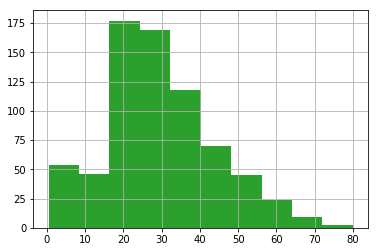

In [8]:
# check if any continuous features (numerical) are skewed
import matplotlib.pyplot as plt
data['Age'].hist()
plt.show()

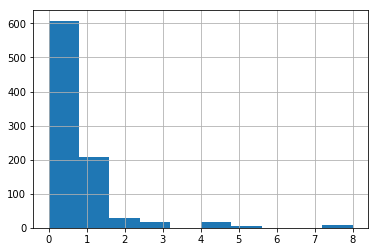

In [9]:
data['SibSp'].hist()
plt.show()

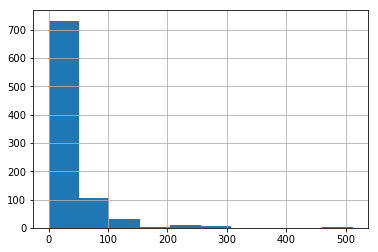

In [10]:
data['Fare'].hist()
plt.show()

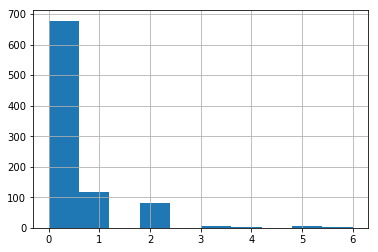

In [11]:
data['Parch'].hist()
plt.show()

In [12]:
# split the data into features and target variable
survive_raw = full_set['Survived']
features_raw = full_set.drop('Survived', axis=1)

In [13]:
# imputation (get rid of the nan)
num_features_raw = ['Age', 'SibSp', 'Fare', 'Parch']
num_imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
features_raw[num_features_raw] = num_imp.fit_transform(features_raw[num_features_raw])

features_raw['Cabin'].fillna('U', inplace=True)
features_raw['Embarked'].fillna('U', inplace=True)

def get_cabin(cabin):
    cabin = cabin[0]
    return cabin

features_raw['Cabin'] = features_raw.apply(lambda row: get_cabin(row['Cabin']), axis=1)
features_raw.isnull().sum()

features_raw_drop_na = features_raw.dropna(axis=0, how='any')

In [14]:
'''
# log transform the skewed data
skewed = ['Age', 'SibSp', 'Fare', 'Parch']
features_log_transformed = pd.DataFrame(data = features_raw_drop_na)
features_log_transformed[skewed] = features_raw_drop_na[skewed].apply(lambda x: np.log(x + 1))
'''
# normalizing numerical features
scaler = MinMaxScaler()
numerical = ['Age', 'SibSp', 'Fare', 'Parch']
features_log_minmax_transform = pd.DataFrame(data = features_raw_drop_na)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_raw_drop_na[numerical])

In [15]:
# creating the final feature set
cat_features_raw = ['Pclass', 'Name', 'Sex', 'Cabin', 'Embarked']

final_cat_features = pd.get_dummies(features_log_minmax_transform[cat_features_raw])
final_num_features = features_log_minmax_transform[numerical]
final_features = pd.concat([final_cat_features, final_num_features], axis = 1)

In [16]:
# now that we have done feature engineering with both train and test data, we need to split them apart again
train_features = final_features[:len(data.index)]
train_target = survive_raw[:len(data.index)]

test_features = final_features[len(data.index):]

In [17]:
# shuffle and split the data into training and cross-validation sets
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 712 samples.
Testing set has 179 samples.


In [18]:
# NAIVE PREDICTOR PERFORMANCE
# if we chose a model that always predict '1' (i.e. passenger survives) then what is the model's accuracy and F-score?
accuracy = float(np.sum(survive_raw == 1))/len(survive_raw)
recall = 1
precision = accuracy

beta = 0.5
fscore = (1 + beta**2) * (precision*recall) / ((beta**2 * precision) + recall)

# print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2613, F-score: 0.3066]


In [19]:
# ML IMPLEMENTATION
# first we call our DT classifier function
clf1 = DecisionTreeClassifier(random_state=0)
# train our DT classifier with the training data
clf1.fit(X_train, y_train)
# make predictions with CV
clf1_predictions = clf1.predict(X_test)
# find accuracy and f1 score of our DT model
DT_accuracy = accuracy_score(y_test, clf1_predictions)
DT_F1 = f1_score(y_test, clf1_predictions)
# print the results 
print "Decision Tree Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(DT_accuracy, DT_F1)

Decision Tree Predictor: [Accuracy score: 0.7542, F-score: 0.6716]


In [20]:
# we repeat the above process with another learner
# first we call our SVM classifier function
clf2 = svm.SVC(random_state=0)
# train our SVM classifier with the training data
clf2.fit(X_train, y_train)
# make predictions with CV
clf2_predictions = clf2.predict(X_test)
# find accuracy and f1 score of our SVM model
SVM_accuracy = accuracy_score(y_test, clf2_predictions)
SVM_F1 = f1_score(y_test, clf2_predictions)
# print the results 
print "SVM Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(SVM_accuracy, SVM_F1)

SVM Predictor: [Accuracy score: 0.7933, F-score: 0.7299]


In [21]:
# we repeat the above process with a third learner
# first we call our SVM classifier function
clf3 = KNeighborsClassifier()
# train our DT classifier with the training data
clf3.fit(X_train, y_train)
# make predictions with CV
clf3_predictions = clf3.predict(X_test)
# find accuracy and f1 score of our DT model
kNN_accuracy = accuracy_score(y_test, clf3_predictions)
kNN_F1 = f1_score(y_test, clf3_predictions)
# print the results 
print "kNN Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(kNN_accuracy, kNN_F1)

kNN Predictor: [Accuracy score: 0.8212, F-score: 0.7538]


In [22]:
# we repeat the above process with a forth learner
# first we call our SVM classifier function
clf4 = RandomForestClassifier(max_depth=2, random_state=0)
# train our DT classifier with the training data
clf4.fit(X_train, y_train)
# make predictions with CV
clf4_predictions = clf4.predict(X_test)
# find accuracy and f1 score of our DT model
RF_accuracy = accuracy_score(y_test, clf4_predictions)
RF_F1 = f1_score(y_test, clf4_predictions)
# print the results 
print "Random Forest Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(RF_accuracy, RF_F1)

Random Forest Predictor: [Accuracy score: 0.7933, F-score: 0.7299]


In [28]:
# GRID SEARCH
# after we have found the best performing model, we can run grid-search to make the model perform even better
# set our classifier as the best performing classifier
clf = clf3
# choose some parameters for gridsearch
parameters = {'n_neighbors':[3, 4, 5, 6, 7], 'weights':['uniform', 'distance']}
# make an fbeta score scoring object
scorer = make_scorer(f1_score)
# perform grid search on the classifier using 'scorer' as the scoring method using gridsearch
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring = scorer)
# fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)
# get the estimator
best_clf = grid_fit.best_estimator_
# make predictions using the new optimized model
best_predictions = best_clf.predict(X_test)

# find accuracy and f1 score of our optimized kNN model
kNN_optimized_accuracy = accuracy_score(y_test, best_predictions)
kNN_optimized_F1 = f1_score(y_test, best_predictions)

In [29]:
# print results of the benchmark, un-optimized and the optimized models
print "Naive predictor:"
print "[Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)
print "Un-optimized kNN:"
print "[Accuracy score: {:.4f}, F-score: {:.4f}]".format(kNN_accuracy, kNN_F1)
print "Optimized kNN:"
print "[Accuracy score: {:.4f}, F-score: {:.4f}]".format(kNN_optimized_accuracy, kNN_optimized_F1)

Naive predictor:
[Accuracy score: 0.2613, F-score: 0.3066]
Un-optimized kNN:
[Accuracy score: 0.8212, F-score: 0.7538]
Optimized kNN:
[Accuracy score: 0.8156, F-score: 0.7402]


In [ ]:
# MAKE TEST PREDICTION
# finally we have our 'perfect' model and it is time to make predictions for our test set
output = best_clf.predict(test_features).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv("test.csv")
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('output4.csv',index=False)

# this output scored 0.78947 on Kaggle